In [1]:
# for running this it should be on the root of the project
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim
import argparse
import os
from tqdm import tqdm
import sys
sys.path.insert(0, '/Users/maruanottoni/home/master/research/graph-corr-embedd/src')

from models.SAE import StackedSparseAutoencoder
from utils.conn_data import save_pickle
from utils.parsers import str_2_bool
from data.Simulation1Loader import Simulation1Loader
from simulation.GraphSim import GraphSim
from utils.activation_functions import sigmoid

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.stats import spearmanr, norm
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

# Defining params

In [79]:
simulation_name = 'simulation2_test_spectrum'
source_path = f'/Users/maruanottoni/home/master/research/graph-corr-embedd/data/simulations/{simulation_name}'
n_simulations = 10
n_graphs = 10
n_nodes = 10

# Start simluation

In [18]:
# Check if path exists
output_path = f"{source_path}/data/inputs/{simulation_name}"
if not os.path.exists(output_path):
    os.makedirs(output_path)

# generate covariance between gaussian random variables
graph_classes = [
    "erdos_renyi",
    "om_geometric",
    "random_regular",
    "barabasi_albert",
    "watts_strogatz",
]



In [23]:
s = .5  # Initial value of covariance
all_graphs = {}
for graph_name in tqdm(graph_classes, total=len(graph_classes), desc=f"Simulating graphs for {simulation_name}"):
    gs = GraphSim(graph_name=graph_name)
    graphs_given_cov = []
    for i in range(n_simulations):
        for j in range(n_graphs):
            gs.update_seed()
            save_seed = gs.seed

            # Use 's' in your simulation
            p = gs.get_p_from_bivariate_gaussian(s=s)
            p = sigmoid(np.abs(p))

            if graph_name == "erdos_renyi":
                graph1 = gs.simulate_erdos(n=n_nodes, prob=p[0, 0])
                graph2 = gs.simulate_erdos(n=n_nodes, prob=p[0, 1])
            elif graph_name == "random_geometric":
                graph1 = gs.simulate_geometric(n=n_nodes, radius=p[0, 0])
                graph2 = gs.simulate_geometric(n=n_nodes, radius=p[0, 1])

            sim_graph_info = {
                "n_simulations": i,
                "n_graphs": j,
                "graph1": graph1,
                "graph2": graph2,
                "seed": save_seed,
                "p": p,
                "cov": s
            }
            graphs_given_cov.append(sim_graph_info)

        # Update 's' after each inner loop iteration
        s += s_increment

    all_graphs[f"{np.round(s, 1)}"] = graphs_given_cov


Simulating graphs for simulation2_test_spectrum:   0%|          | 0/5 [00:00<?, ?it/s]/Users/maruanottoni/home/master/research/graph-corr-embedd/src/simulation/GraphSim.py:29: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  p = np.random.multivariate_normal(mean=[0, 0], cov=[[1, s], [s, 1]], size=1)
Simulating graphs for simulation2_test_spectrum: 100%|██████████| 5/5 [00:00<00:00, 135.53it/s]


In [27]:
sample = True
if not sample:
    save_pickle(path=f"{output_path}/all_graph_info.pkl", obj=all_graphs)
else:
    save_pickle(path=f"{output_path}/sample_graph_info.pkl", obj=all_graphs)

# Sketch

In [7]:
import numpy as np
import networkx as nx
from scipy.stats import spearmanr
from tqdm import tqdm

# Initialize variables
n_simulations = 100  # Number of times the whole process is repeated
n_graphs = [20]  # Number of graphs for each simulation
n_nodes = 50  # Size of the graphs
s_initial = 0.5  # Initial covariance value
s_increment = 0.1  # TODO: Increment in covariance after each simulation
graph_classes = ['erdos_renyi', 'random_geometric']  # Extend this list based on your graph types

all_graphs = {}
simulation_name = "Graph Correlation Analysis"

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.stats import spearmanr
from tqdm import tqdm

all_graphs = {}

# Function to run the simulation
def run_simulation(n_graphs, n_simulations, n_nodes, s_initial, s_increment, graph_classes):
    for n_graph in n_graphs:
        for graph_name in tqdm(graph_classes, desc=f"Simulating graphs for {simulation_name}"):
            gs = GraphSim(graph_name=graph_name)
            graphs_given_cov = []
            s = s_initial  # Reset covariance for each graph type
            all_eigenvalues1 = []
            all_eigenvalues2 = []

            for i in range(n_simulations):
                for j in range(n_graph):
                    gs.update_seed()

                    # Generate parameters and normalize
                    p = gs.get_p_from_bivariate_gaussian(s=s)
                    p = sigmoid(np.abs(p))  # normalize

                    # Simulate graphs based on the graph type
                    if graph_name == "erdos_renyi":
                        graph1 = gs.simulate_erdos(n=n_nodes, prob=p[0, 0])
                        graph2 = gs.simulate_erdos(n=n_nodes, prob=p[0, 1])
                    elif graph_name == "random_geometric":
                        graph1 = gs.simulate_geometric(n=n_nodes, radius=p[0, 0])
                        graph2 = gs.simulate_geometric(n=n_nodes, radius=p[0, 1])
                    # TODO: Add other graph types

                    # Calculate spectral radii
                    largest_eigenvalue1 = max(np.abs(np.linalg.eigvals(nx.adjacency_matrix(graph1).A)))
                    largest_eigenvalue2 = max(np.abs(np.linalg.eigvals(nx.adjacency_matrix(graph2).A)))
                    all_eigenvalues1.append(largest_eigenvalue1)
                    all_eigenvalues2.append(largest_eigenvalue2)

                # Calculate Spearman correlation for the collected eigenvalues
                spearman_correlation = spearmanr(all_eigenvalues1, all_eigenvalues2, nan_policy='omit').correlation

                # Store the results for the current graph type and covariance
                sim_graph_info = {
                    "n_simulations": i,
                    "graph_name": graph_name,
                    "spearman_correlation": spearman_correlation,
                    "cov": s
                }
                graphs_given_cov.append(sim_graph_info)

            # Store the simulation results for each graph type
            all_graphs[graph_name] = graphs_given_cov

    return all_graphs

# Run the simulation
all_graphs = run_simulation(n_graphs, n_simulations, n_nodes, s_initial, s_increment, graph_classes)

Simulating graphs for Graph Correlation Analysis:   0%|          | 0/2 [00:00<?, ?it/s]/Users/maruanottoni/miniforge3/envs/gce/lib/python3.10/site-packages/scipy/sparse/_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


In [ ]:
all_graphs.keys()

dict_keys(['erdos_renyi', 'random_geometric'])

In [ ]:
all_graphs['erdos_renyi']

[{'n_simulations': 0,
  'graph_name': 'erdos_renyi',
  'spearman_correlation': -0.16842105263157892,
  'cov': 0},
 {'n_simulations': 1,
  'graph_name': 'erdos_renyi',
  'spearman_correlation': -0.007692307692307694,
  'cov': 0},
 {'n_simulations': 2,
  'graph_name': 'erdos_renyi',
  'spearman_correlation': -0.06418449569324813,
  'cov': 0},
 {'n_simulations': 3,
  'graph_name': 'erdos_renyi',
  'spearman_correlation': -0.07728551336146273,
  'cov': 0},
 {'n_simulations': 4,
  'graph_name': 'erdos_renyi',
  'spearman_correlation': -0.06589858985898589,
  'cov': 0},
 {'n_simulations': 5,
  'graph_name': 'erdos_renyi',
  'spearman_correlation': -0.05416348357524828,
  'cov': 0},
 {'n_simulations': 6,
  'graph_name': 'erdos_renyi',
  'spearman_correlation': -0.015394371432944831,
  'cov': 0},
 {'n_simulations': 7,
  'graph_name': 'erdos_renyi',
  'spearman_correlation': 0.028038204617367862,
  'cov': 0},
 {'n_simulations': 8,
  'graph_name': 'erdos_renyi',
  'spearman_correlation': -0.0145

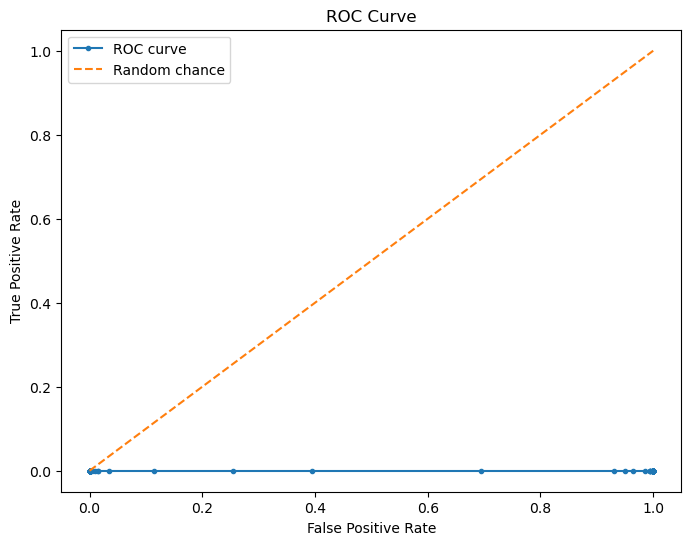

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

thresholds = np.linspace(-1, 1, 100) # spearmanr \in [-1,1]

# Placeholder for TPRs and FPRs
tprs = []
fprs = []

# Iterate over each threshold 
for threshold in thresholds:
    tp, fp, tn, fn = 0, 0, 0, 0
    for simulation_results in all_graphs.values():
        for result in simulation_results:
            # Use previously calculated Spearman correlation as the test statistic
            spearman_correlation = result['spearman_correlation'] 
            
            # Hypothesis: A positive Spearman correlation indicates a correlation between graph parameters
            is_correlated = result['cov'] > 0  # This needs to be defined based on your hypothesis

            # Decide if the result is a TP, FP, TN, or FN based on the threshold
            if spearman_correlation > threshold:
                if is_correlated:
                    tp += 1
                else:
                    fp += 1
            else:
                if is_correlated:
                    fn += 1
                else:
                    tn += 1

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tprs.append(tpr)
    fprs.append(fpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fprs, tprs, marker='.', label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()